In [26]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
import scipy

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
from typing import Optional

import pandas as pd
from IPython.display import Image
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from statsforecast.arima import ARIMASummary, ndiffs, nsdiffs
from statsforecast.models import ARIMA, AutoARIMA, AutoETS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
from utilsforecast.losses import mae, rmse, smape

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image, Markdown, display
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import fourier, pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss, rmse


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import SplineTransformer
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

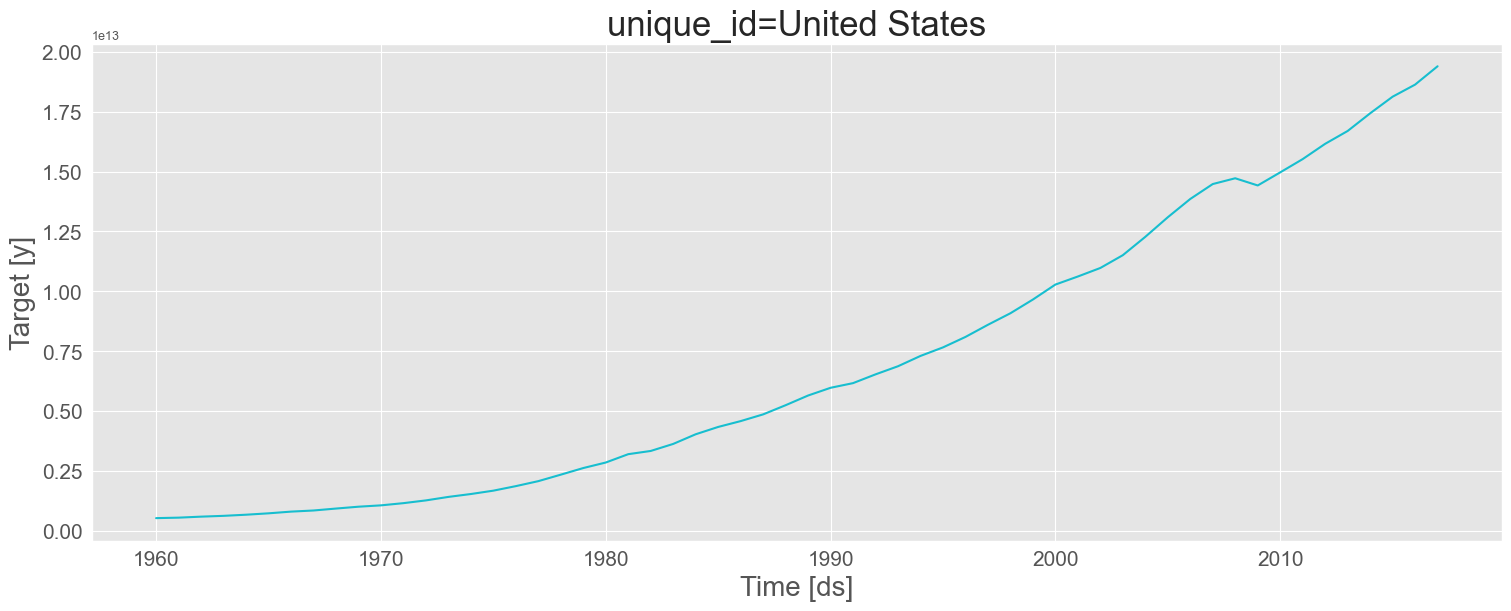

In [27]:
df = pd.read_csv("../DATA/global_economy.csv")
df = df[df.unique_id == "United States"]
df.ds = pd.to_datetime(df.ds, format="%Y")
gdp = df[["unique_id", "ds"]]
gdp["y"] = df["GDP"]
gdp = gdp.reset_index(drop=True)
plot_series(gdp)

kpss_stat: 0.102, kpss_pvalue: 0.10


<Axes: ylabel='y'>

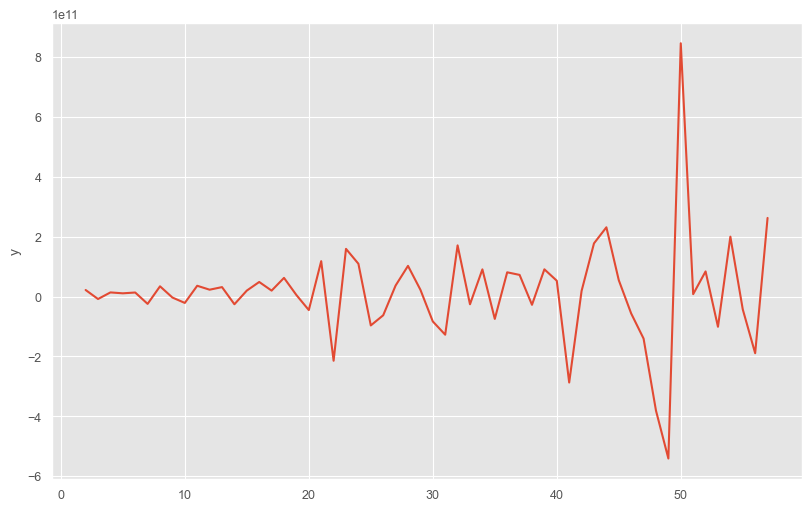

In [28]:
kpss_stat, kpss_pvalue, _, _ = kpss(gdp.y.diff().diff().dropna())
print(f"kpss_stat: {kpss_stat:.3f}, kpss_pvalue: {kpss_pvalue:.2f}")

sns.lineplot(gdp.y.diff().diff())

## Let's apply a box cox transform because the 2nd derivation is not stationnary

<Axes: ylabel='boxcox_y'>

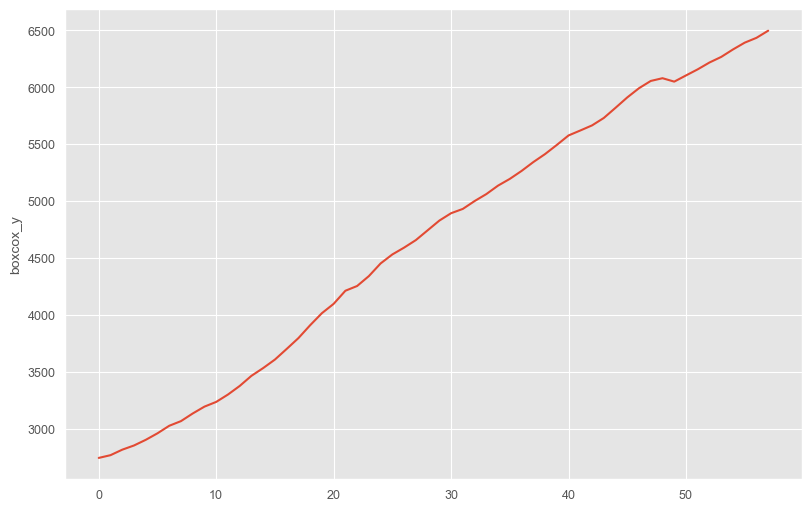

In [29]:
gdp["boxcox_y"], lbd = boxcox(gdp.y)
sns.lineplot(gdp.boxcox_y)

kpss_stat: 0.262, kpss_pvalue: 0.10


<Axes: ylabel='boxcox_y'>

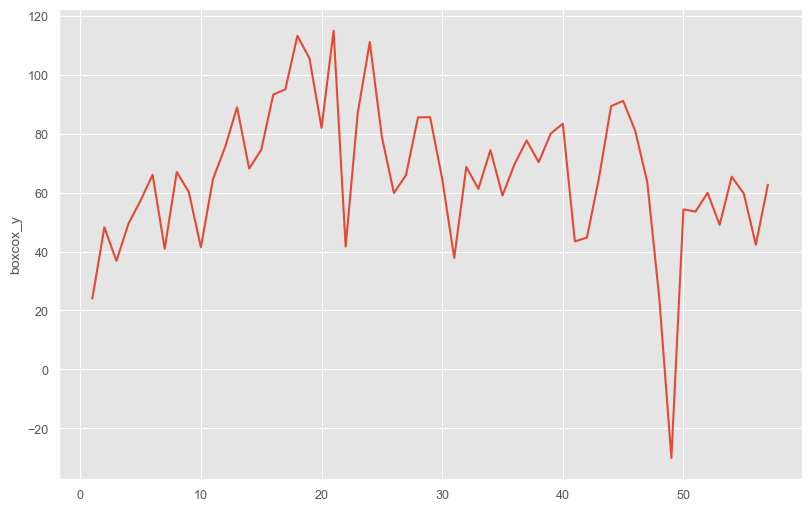

In [30]:
kpss_stat, kpss_pvalue, _, _ = kpss(gdp.boxcox_y.diff().dropna())
print(f"kpss_stat: {kpss_stat:.3f}, kpss_pvalue: {kpss_pvalue:.2f}")

sns.lineplot(gdp.boxcox_y.diff())

## Both series are stationnary according to the kpps test   
## let's fit AutoArima to both and then use crossvalidation to evaluate the models on the real data   

In [45]:
splits = TimeSeriesSplit(n_splits=30, test_size=1)

untransformed_metric = []
transformed_metric = []

for train, test in splits.split(gdp.y):
    untransformed = AutoARIMA().fit(gdp.y.iloc[train])
    prediction = untransformed.predict(h=1)["mean"]
    untransformed_metric.append(root_mean_squared_error(gdp.y.iloc[test], prediction))


for train, test in splits.split(gdp.boxcox_y):
    transformed = AutoARIMA().fit(gdp.boxcox_y.iloc[train])
    transformed_prediction = transformed.predict(h=1)["mean"]
    untransformed_prediction = inv_boxcox(transformed_prediction, lbd)
    transformed_metric.append(
        root_mean_squared_error(gdp.y.iloc[test], untransformed_prediction)
    )

In [52]:
print(
    f"""
    Arima on Original data : {int(np.mean(untransformed_metric))}
    Arima on BoxCox Transform : {int(np.mean(transformed_metric))}
    """
)


    Arima on Original data : 191181160793
    Arima on BoxCox Transform : 139080659686
    


Text(0.5, 1.0, 'Transformed')

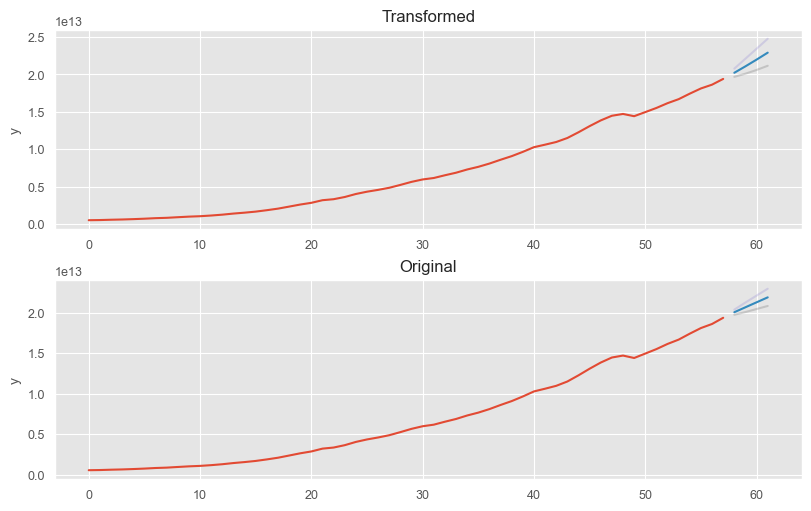

In [87]:
_, axes = plt.subplots(2, 1)

transformed = AutoARIMA().fit(gdp.boxcox_y)
pred = transformed.predict(h=4, level=[95])
pred_mean = inv_boxcox(transformed.predict(h=4, level=[95])["mean"], lbd)
pred_hi95 = inv_boxcox(transformed.predict(h=4, level=[95])["hi-95"], lbd)
pred_lo95 = inv_boxcox(transformed.predict(h=4, level=[95])["lo-95"], lbd)


sns.lineplot(x=range(0, len(gdp)), y=gdp.y, ax=axes[0])
sns.lineplot(x=range(len(gdp), len(gdp) + 4), y=pred_mean, ax=axes[0])
sns.lineplot(x=range(len(gdp), len(gdp) + 4), y=pred_hi95, alpha=0.3, ax=axes[0])
sns.lineplot(x=range(len(gdp), len(gdp) + 4), y=pred_lo95, alpha=0.3, ax=axes[0])

original = AutoARIMA().fit(gdp.y)

sns.lineplot(x=range(0, len(gdp)), y=gdp.y, ax=axes[1])
sns.lineplot(
    x=range(len(gdp), len(gdp) + 4), y=original.predict(h=4)["mean"], ax=axes[1]
)
sns.lineplot(
    x=range(len(gdp), len(gdp) + 4),
    y=original.predict(h=4, level=[95])["hi-95"],
    alpha=0.3,
    ax=axes[1],
)
sns.lineplot(
    x=range(len(gdp), len(gdp) + 4),
    y=original.predict(h=4, level=[95])["lo-95"],
    alpha=0.3,
    ax=axes[1],
)

axes[1].set_title("Original")
axes[0].set_title("Transformed")

<Axes: >

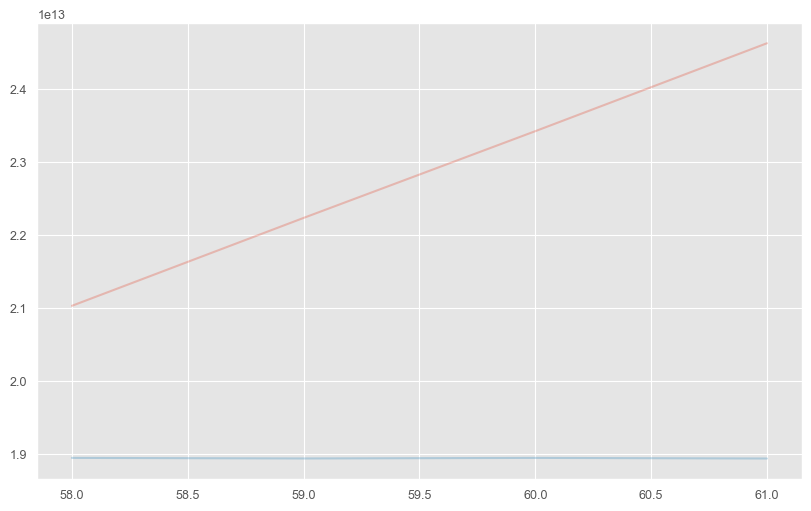

In [88]:
original = AutoETS().fit(gdp.y)

sns.lineplot(x=range(0, len(gdp)), y=gdp.y)
sns.lineplot(
    x=range(len(gdp), len(gdp) + 4), y=original.predict(h=4)["mean"]
)
sns.lineplot(
    x=range(len(gdp), len(gdp) + 4),
    y=original.predict(h=4, level=[95])["hi-95"],
    alpha=0.3,
)
sns.lineplot(
    x=range(len(gdp), len(gdp) + 4),
    y=original.predict(h=4, level=[95])["lo-95"],
    alpha=0.3,
)